# コード5-2：拡散方程式の数値計算の実装

『ウイルス感染の数理モデルとシミュレーション ーデータを定量的に理解するー』

拡散方程式の数値計算の実装の例をまとめる。

## ライブラリ、パッケージ（モジュール）の読み込み

In [1]:
## 必要があればインストール
# install.packages("ggplot2", "patchwork")

In [2]:
library(ggplot2)
library(patchwork)

このサンプルコードでは、数学コラム０４で紹介された、有限要素法には触れず、有限差分法による数値計算を紹介します。

- 有限要素法  
https://ja.wikipedia.org/wiki/%E6%9C%89%E9%99%90%E8%A6%81%E7%B4%A0%E6%B3%95
- 有限差分法  
https://ja.wikipedia.org/wiki/%E6%9C%89%E9%99%90%E5%B7%AE%E5%88%86
- FreeFEM++  
Documentationが充実し、可視化などのツールが充実していますが、多様な方程式を取り扱うためには弱形式の導出など偏微分方程式に関する理解が必要です。

## 拡散方程式の数値計算


数学コラム０４：ウイルス感染の時空間動態

二次元平面$(x,y) \in \mathbb{R}^2$の領域$\Omega \in \mathbb{R}^2$における、時刻$0<t<T$での個体数$n(t,x,y)$に対する拡散方程式

$$
\frac{\partial n(t,x,y)}{\partial t} = D\left( \frac{\partial^2 n(t,x,y)}{{\partial x}^2} + \frac{\partial^2 n(t,x,y)}{{\partial y}^2} \right) = D\Delta n(t,x,y)
$$

について、数値計算を行う。

有限差分法をを用いて、xおよびy方向の離散化を以下のようにする。

$$
n_{x_{i},y_{j},t_{k+1}} =
n_{x_{i},y_{j},t_k} +
D \left( \frac{n_{x_{i-1},y_{j},t_k} + n_{x_{i+1},y_{j},t_k} + n_{x_{i},y_{j-1},t_k} + n_{x_{i},y_{j+1},t_k} - 4 n_{x_{i},y_{j},t_k}}{{\Delta h}^2} \right)
\Delta t
$$

ここで、$x_{i+1} = x_i + \Delta h$、$y_{j+1} = y_j + \Delta h$、$t_{k+1} = t_k + \Delta t$である。

In [3]:
## パラメータと初期条件

D <- 1.0
n_0 <- 100

num_x <- num_y <- 100
num_t <- 1000

len_x <- len_y <- 100
len_t = 20

dh <- len_x/num_x
dt <- len_t/num_t

In [4]:
## ディリクレ境界条件

n_left <- n_right <- n_top <- n_bottom <- 1

In [5]:
n_old <- matrix(0, nrow = num_x + 2, ncol = num_y + 2)
n_old[num_x%/%2, num_y%/%2] <- n_0

count_plt <- 1
list_time <- list(0)
list_plt <- list(n_old)
num_plt <- 10

for (i in 1:num_t){

    n_new <- n_old
    
    ## 有限差分法による更新
    n_new[2:(num_x+1), 2:(num_y+1)] <- n_old[2:(num_x+1), 2:(num_y+1)] + D*((n_old[1:(num_x), 2:(num_y+1)] + n_old[3:(num_x+2), 2:(num_y+1)] +
                                                                             n_old[2:(num_x+1), 1:(num_y)] + n_old[2:(num_x+1), 3:(num_y+2)] -
                                                                             4.0*n_old[2:(num_x+1), 2:(num_y+1)])/dh^2)*dt
            
    ## ディリクレ境界条件による更新
    n_new[1,] <- n_left
    n_new[ncol(n_new),] <- n_right
    n_new[, 1] <- n_top
    n_new[, nrow(n_new)] <- n_bottom

    if (i + 1 > count_plt*(num_t/num_plt)){
        list_time[[length(list_time) + 1]] <- i*dt
        list_plt[[length(list_plt) + 1]] <- n_new
        count_plt <- count_plt + 1
    }
                
    n_old <- n_new
}

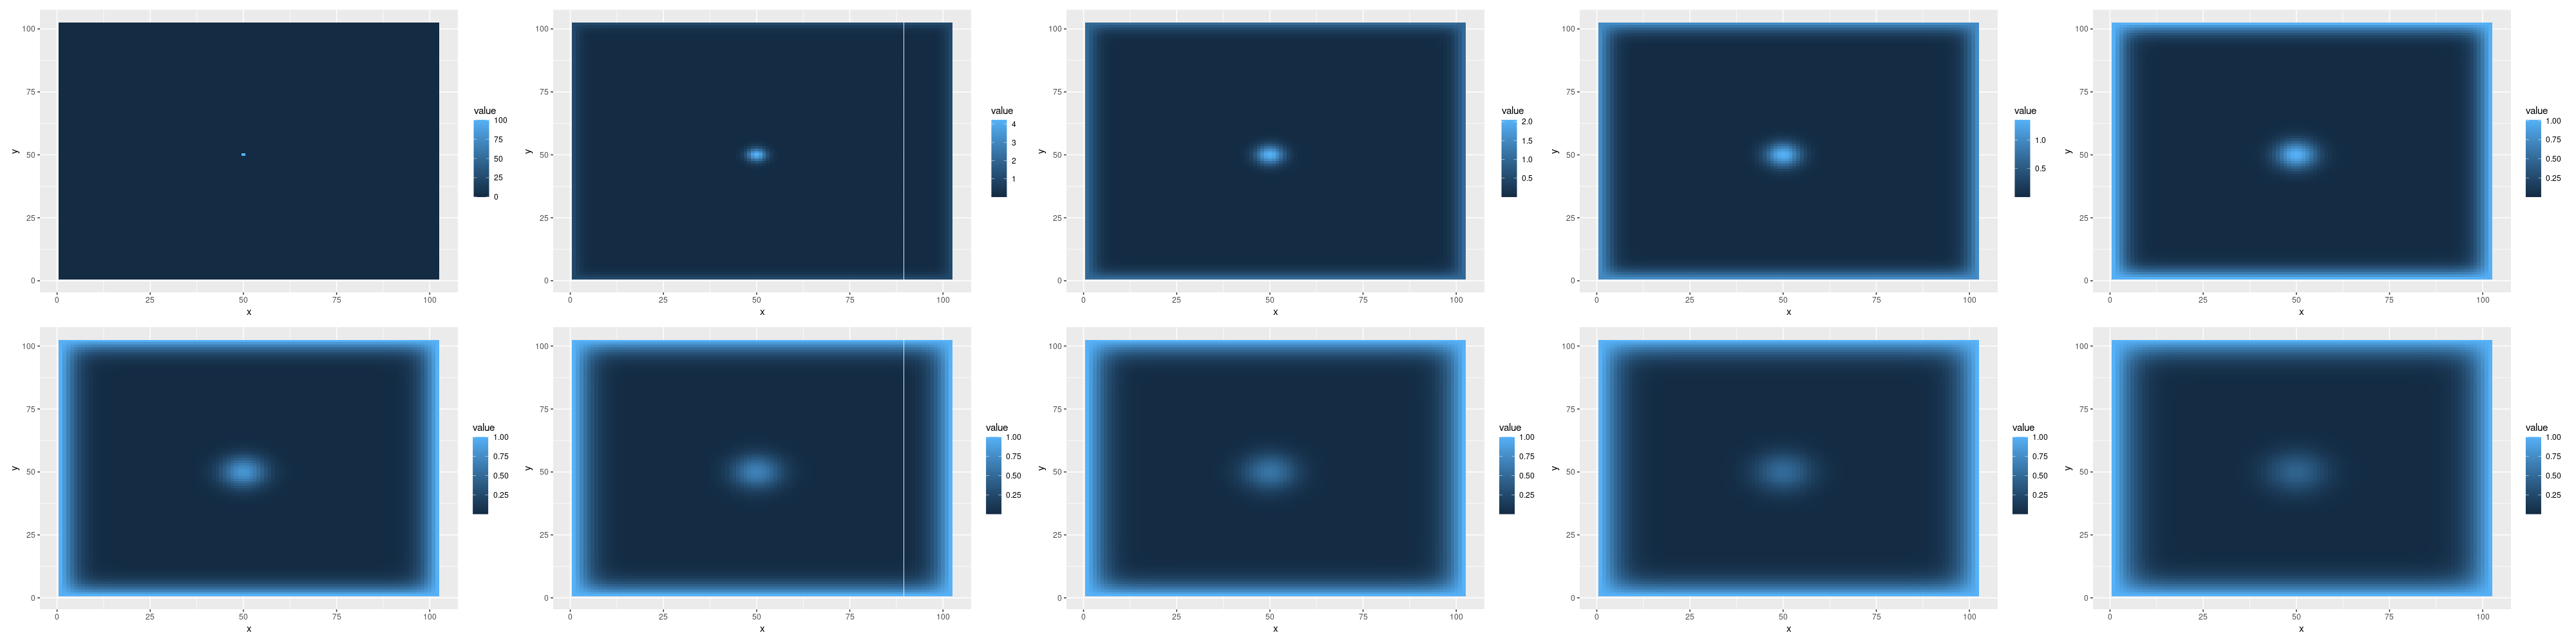

In [6]:
plt <- list()

for (i in 1:num_plt) {
    
    data_temp <- data.frame()
    for (j in 1:nrow(list_plt[[i]])) {
        data_temp <- rbind(data_temp,
                           data.frame(x = j, y = 1:ncol(list_plt[[i]]),
                                      value = list_plt[[i]][j,]))
    }
    
    
    plt[[i]] <- ggplot(data = data_temp, aes(x = x, y = y, fill = value)) +
        geom_tile()
}

options(repr.plot.width = 40, repr.plot.height = 10, repr.plot.res = 100) ## プロットの描画サイズの設定
wrap_plots(plt) + plot_layout(nrow = 2)

In [7]:
## ノイマン境界条件

dn_left <- dn_top <- 1
dn_right <- dn_bottom <- -1

In [8]:
n_old <- matrix(0, nrow = num_x + 2, ncol = num_y + 2)
n_old[num_x%/%2, num_y%/%2] <- n_0

count_plt <- 1
list_time <- list(0)
list_plt <- list(n_old)
num_plt <- 10

for (i in 1:num_t){

    n_new <- n_old
    
    ## 有限差分法による更新
    n_new[2:(num_x+1), 2:(num_y+1)] <- n_old[2:(num_x+1), 2:(num_y+1)] + D*((n_old[1:(num_x), 2:(num_y+1)] + n_old[3:(num_x+2), 2:(num_y+1)] +
                                                                             n_old[2:(num_x+1), 1:(num_y)] + n_old[2:(num_x+1), 3:(num_y+2)] -
                                                                             4.0*n_old[2:(num_x+1), 2:(num_y+1)])/dh^2)*dt
            
    ## ノイマン境界条件による更新
    n_new[1,] <- n_new[2,] - dn_left*dh
    n_new[ncol(n_new),] <- n_new[ncol(n_new)-1,] + dn_right*dh
    n_new[, 1] <- n_new[, 2] - dn_top*dh
    n_new[, nrow(n_new)] <- n_new[, nrow(n_new)-1] + dn_bottom*dh

    if (i + 1 > count_plt*(num_t/num_plt)){
        list_time[[length(list_time) + 1]] <- i*dt
        list_plt[[length(list_plt) + 1]] <- n_new
        count_plt <- count_plt + 1
    }
                
    n_old <- n_new
}

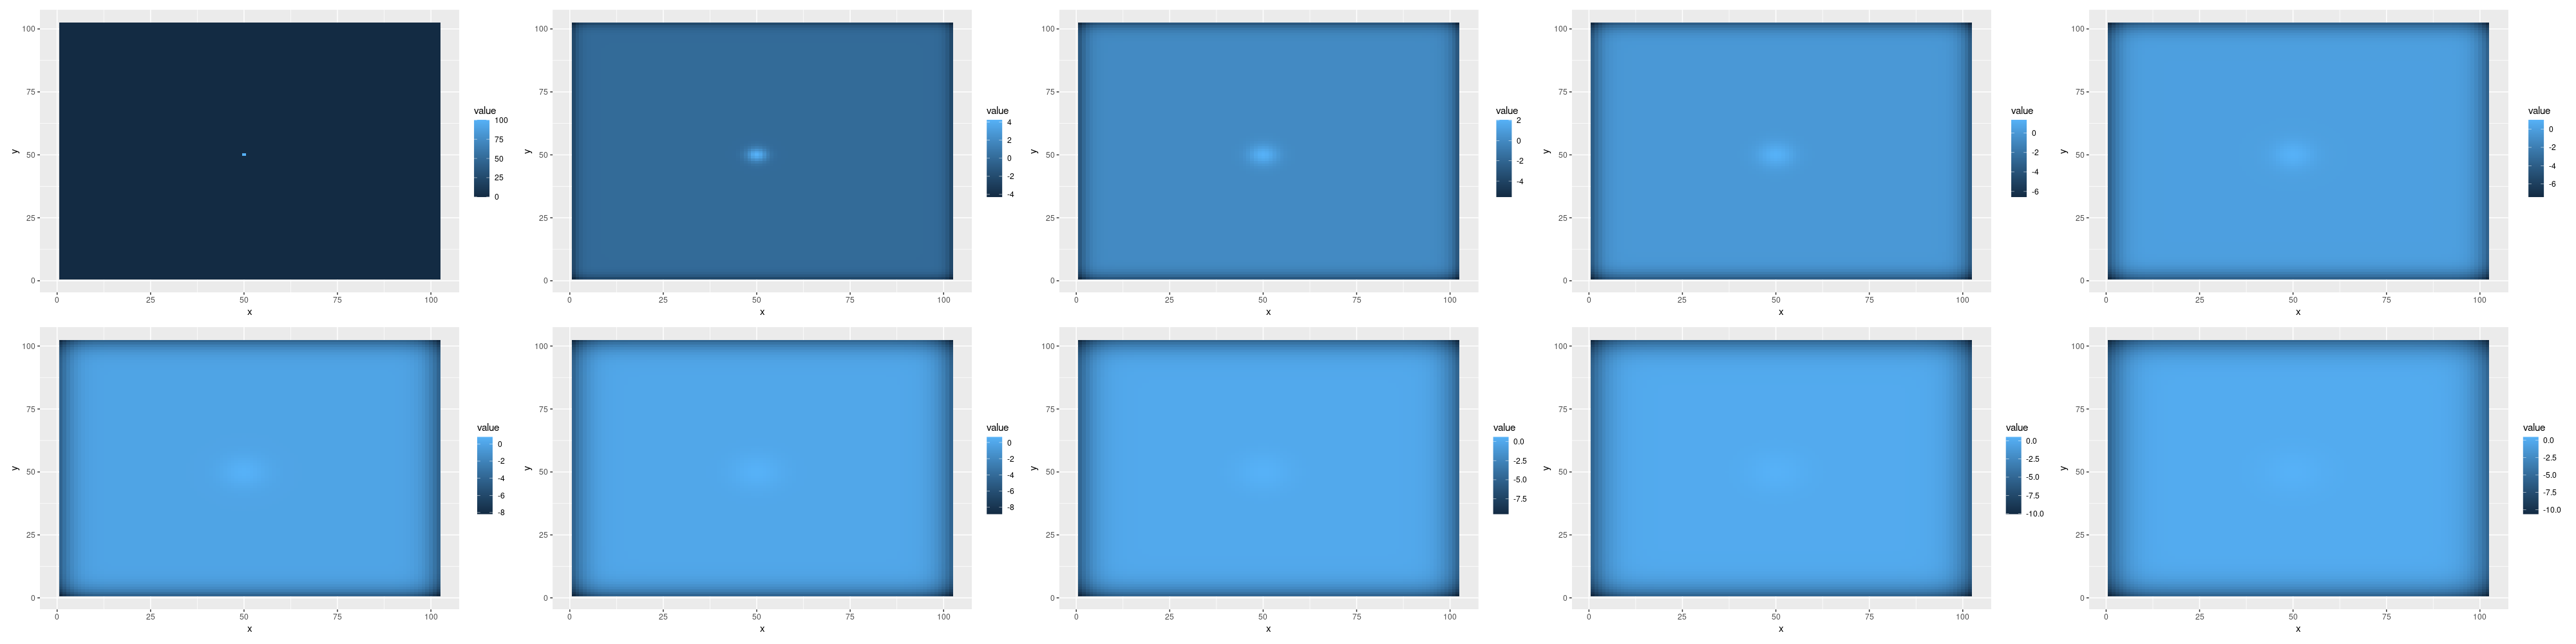

In [9]:
plt <- list()

for (i in 1:num_plt) {
    
    data_temp <- data.frame()
    for (j in 1:nrow(list_plt[[i]])) {
        data_temp <- rbind(data_temp,
                           data.frame(x = j, y = 1:ncol(list_plt[[i]]),
                                      value = list_plt[[i]][j,]))
    }
    
    
    plt[[i]] <- ggplot(data = data_temp, aes(x = x, y = y, fill = value)) +
        geom_tile()
}

options(repr.plot.width = 40, repr.plot.height = 10, repr.plot.res = 100) ## プロットの描画サイズの設定
wrap_plots(plt) + plot_layout(nrow = 2)

## 拡散反応方程式の数値計算

２次元の空間領域

$$
\frac{\partial n(t,x,y)}{\partial t} = D\left( \frac{\partial^2 n(t,x,y)}{{\partial x}^2} + \frac{\partial^2 n(t,x,y)}{{\partial y}^2} \right) + f \left( n(t, x, y) \right)
$$

について、数値計算を行う。

有限差分法をを用いて、xおよびy方向の離散化を以下のようにする。

$$
n_{x_{i},y_{j},t_{k+1}} =
n_{x_{i},y_{j},t_k} +
D \left( \frac{n_{x_{i-1},y_{j},t_k} + n_{x_{i+1},y_{j},t_k} + n_{x_{i},y_{j-1},t_k} + n_{x_{i},y_{j+1},t_k} - 4 n_{x_{i},y_{j},t_k}}{{\Delta h}^2} \right)
\Delta t +
f \left( n_{x_{i},y_{j},t_k} \right) \Delta t
$$

ここで、$x_{i+1} = x_i + \Delta h$、$y_{j+1} = y_j + \Delta h$、$t_{k+1} = t_k + \Delta t$である。

ここではグレイ・スコットモデル

$$
\frac{\partial u(t,x,y)}{\partial t} = D_u \left( \frac{\partial^2 u(t,x,y)}{{\partial x}^2} + \frac{\partial^2 u(t,x,y)}{{\partial y}^2} \right) - u v^2 + a(1 - u) \\
\frac{\partial v(t,x,y)}{\partial t} = D_v \left( \frac{\partial^2 v(t,x,y)}{{\partial x}^2} + \frac{\partial^2 v(t,x,y)}{{\partial y}^2} \right) + u v^2 - (a + k) v
$$

を例に、平衡解と進行波解を観察する。

In [10]:
### 平衡解

## パラメータと初期条件

Du <- 2e-5
Dv <- Du/2
a <- 0.022
k <- 0.051
u_0 <- 1
v_0 <- 0

num_x <- num_y <- 100
num_t <- 10000

len_x <- len_y <- 1
len_t <- 10000

dh <- len_x/num_x
dt <- len_t/num_t

In [11]:
## ノイマン境界条件

du_left <- du_right <- du_top <- du_bottom <- 0
dv_left <- dv_right <- dv_top <- dv_bottom <- 0

In [12]:
u_old <- matrix(1, nrow = num_x + 2, ncol = num_y + 2)
u_old[(num_x%/%2 - 10%/%2):(num_x%/%2 + 10%/%2), (num_y%/%2 - 10%/%2):(num_y%/%2 + 10%/%2)] <- 0.5

v_old <- matrix(0, nrow = num_x + 2, ncol = num_y + 2)
v_old[(num_x%/%2 - 10%/%2):(num_x%/%2 + 10%/%2), (num_y%/%2 - 10%/%2):(num_y%/%2 + 10%/%2)] <- 0.2

count_plt <- 1
list_time <- list(0)
list_plt_u <- list(u_old)
list_plt_v <- list(v_old)
num_plt <- 10


for (i in 1:num_t) {

    u_new <- u_old
    v_new <- v_old
    
    ## 有限差分法による更新
    u_new[2:(num_x+1), 2:(num_y+1)] = u_old[2:(num_x+1), 2:(num_y+1)] + Du*((u_old[1:(num_x), 2:(num_y+1)] + u_old[3:(num_x+2), 2:(num_y+1)] +
                                                                             u_old[2:(num_x+1), 1:(num_y)] + u_old[2:(num_x+1), 3:(num_y+2)] -
                                                                             4.0*u_old[2:(num_x+1), 2:(num_y+1)])/(dh^2))*dt +
                                    (- u_old[2:(num_x+1), 2:(num_y+1)]*(v_old[2:(num_x+1), 2:(num_y+1)]^2) + a*(1.0 - u_old[2:(num_x+1), 2:(num_y+1)]))*dt
    
    v_new[2:(num_x+1), 2:(num_y+1)] = v_old[2:(num_x+1), 2:(num_y+1)] + Dv*((v_old[1:(num_x), 2:(num_y+1)] + v_old[3:(num_x+2), 2:(num_y+1)] +
                                                                             v_old[2:(num_x+1), 1:(num_y)] + v_old[2:(num_x+1), 3:(num_y+2)] -
                                                                             4.0*v_old[2:(num_x+1), 2:(num_y+1)])/(dh^2))*dt +
                                    (u_old[2:(num_x+1), 2:(num_y+1)]*(v_old[2:(num_x+1), 2:(num_y+1)]^2) - (a + k)*v_old[2:(num_x+1), 2:(num_y+1)])*dt
    
            
    # ノイマン境界条件による更新
    u_new[1, ] <- u_new[2, ] - du_left*dh
    u_new[ncol(u_new), ] <- u_new[ncol(u_new)-1, ] + du_right*dh
    u_new[, 1] <- u_new[, 2] - du_top*dh
    u_new[, nrow(u_new)] <- u_new[, nrow(u_new)-1] + du_bottom*dh

    v_new[1, ] <- v_new[2, ] - dv_left*dh
    v_new[ncol(v_new), ] <- v_new[ncol(v_new)-1, ] + dv_right*dh
    v_new[, 1] <- v_new[, 2] - dv_top*dh
    v_new[, nrow(v_new)] <- v_new[, nrow(v_new)-1] + dv_bottom*dh
    
    
    if (i + 1 > count_plt*(num_t/num_plt)){
        list_time[[length(list_time) + 1]] <- i*dt
        list_plt_u[[length(list_plt_u) + 1]] <- u_new
        list_plt_v[[length(list_plt_v) + 1]] <- v_new
        count_plt <- count_plt + 1
    }
                
    u_old <- u_new
    v_old <- v_new
}

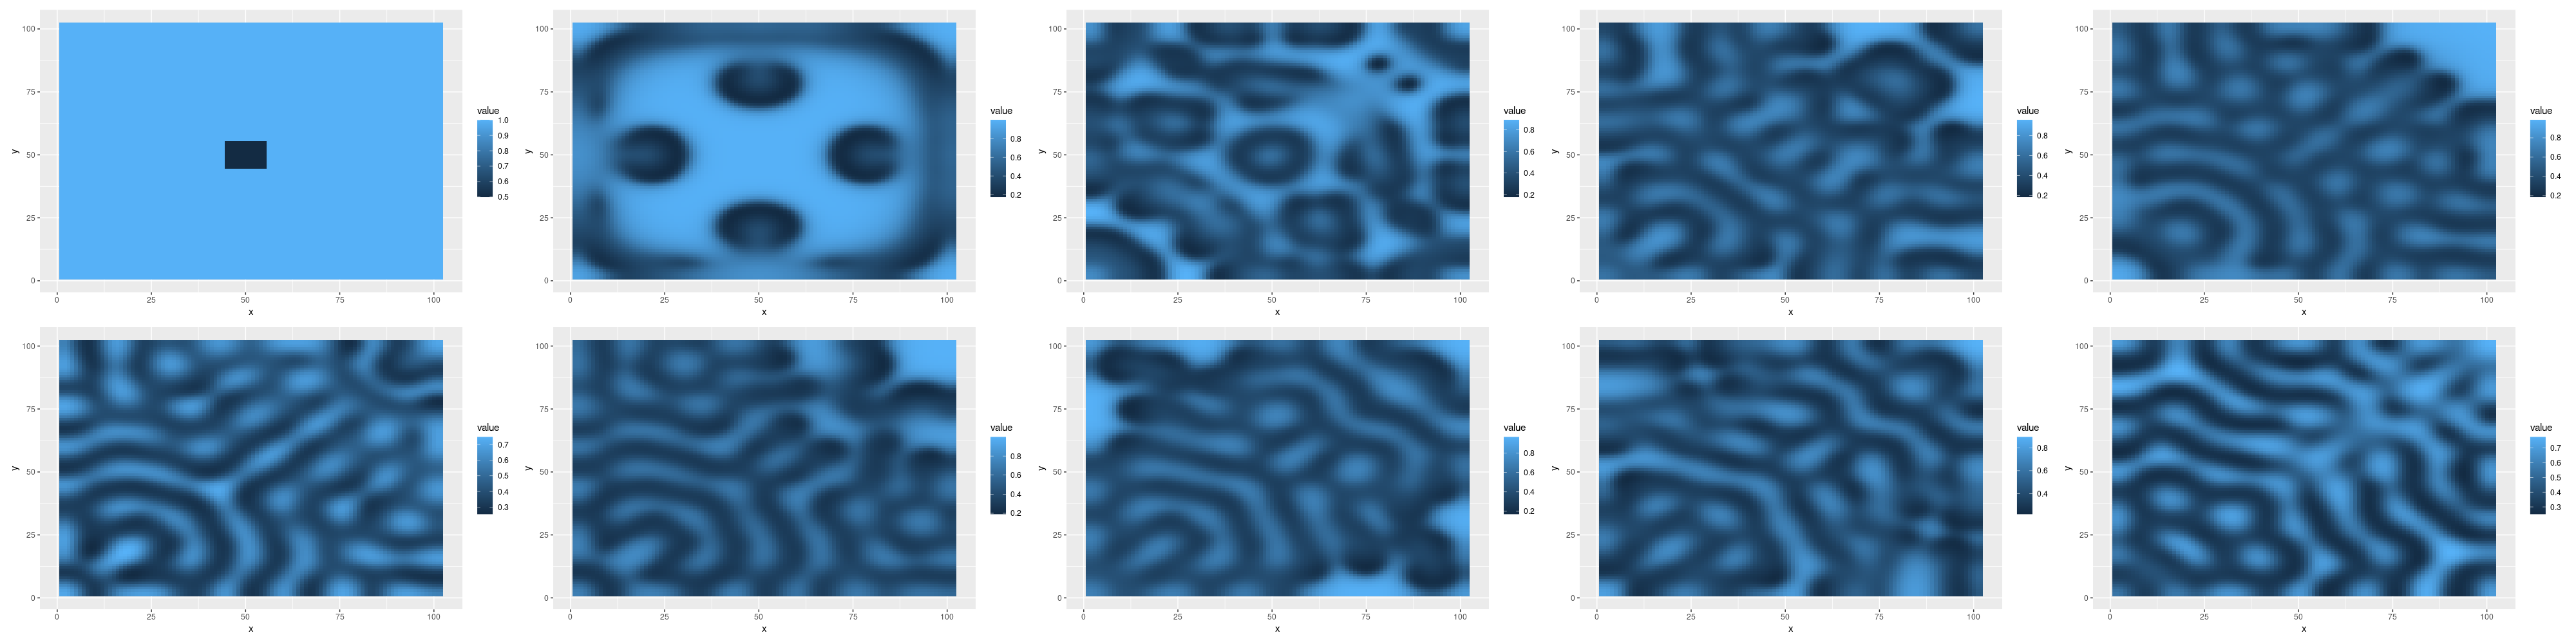

In [13]:
plt <- list()

for (i in 1:num_plt) {
    
    data_temp <- data.frame()
    for (j in 1:nrow(list_plt_u[[i]])) {
        data_temp <- rbind(data_temp,
                           data.frame(x = j, y = 1:ncol(list_plt_u[[i]]),
                                      value = list_plt_u[[i]][j,]))
    }
    
    
    plt[[i]] <- ggplot(data = data_temp, aes(x = x, y = y, fill = value)) +
        geom_tile()
}

options(repr.plot.width = 40, repr.plot.height = 10, repr.plot.res = 100) ## プロットの描画サイズの設定
wrap_plots(plt) + plot_layout(nrow = 2)

In [14]:
### 進行波解

## パラメータと初期条件

Du <- 2e-5
Dv <- 1e-5
a <- 0.025
k <- 0.05
u_0 <- 1
v_0 <- 0

num_x <- num_y <- 100
num_t <- 1000

len_x <- len_y <- 1
len_t <- 500

dh <- len_x/num_x
dt <- len_t/num_t

In [15]:
## ノイマン境界条件

du_left <- du_right <- du_top <- du_bottom <- 0
dv_left <- dv_right <- dv_top <- dv_bottom <- 0

In [16]:
u_old <- matrix(1, nrow = num_x + 2, ncol = num_y + 2)
u_old[(num_x%/%2 - 10%/%2):(num_x%/%2 + 10%/%2), (num_y%/%2 - 10%/%2):(num_y%/%2 + 10%/%2)] <- 0.5

v_old <- matrix(0, nrow = num_x + 2, ncol = num_y + 2)
v_old[(num_x%/%2 - 10%/%2):(num_x%/%2 + 10%/%2), (num_y%/%2 - 10%/%2):(num_y%/%2 + 10%/%2)] <- 0.2

count_plt <- 1
list_time <- list(0)
list_plt_u <- list(u_old)
list_plt_v <- list(v_old)
num_plt <- 10


for (i in 1:num_t) {

    u_new <- u_old
    v_new <- v_old
    
    ## 有限差分法による更新
    u_new[2:(num_x+1), 2:(num_y+1)] = u_old[2:(num_x+1), 2:(num_y+1)] + Du*((u_old[1:(num_x), 2:(num_y+1)] + u_old[3:(num_x+2), 2:(num_y+1)] +
                                                                             u_old[2:(num_x+1), 1:(num_y)] + u_old[2:(num_x+1), 3:(num_y+2)] -
                                                                             4.0*u_old[2:(num_x+1), 2:(num_y+1)])/(dh^2))*dt +
                                    (- u_old[2:(num_x+1), 2:(num_y+1)]*(v_old[2:(num_x+1), 2:(num_y+1)]^2) + a*(1.0 - u_old[2:(num_x+1), 2:(num_y+1)]))*dt
    
    v_new[2:(num_x+1), 2:(num_y+1)] = v_old[2:(num_x+1), 2:(num_y+1)] + Dv*((v_old[1:(num_x), 2:(num_y+1)] + v_old[3:(num_x+2), 2:(num_y+1)] +
                                                                             v_old[2:(num_x+1), 1:(num_y)] + v_old[2:(num_x+1), 3:(num_y+2)] -
                                                                             4.0*v_old[2:(num_x+1), 2:(num_y+1)])/(dh^2))*dt +
                                    (u_old[2:(num_x+1), 2:(num_y+1)]*(v_old[2:(num_x+1), 2:(num_y+1)]^2) - (a + k)*v_old[2:(num_x+1), 2:(num_y+1)])*dt
    
            
    # ノイマン境界条件による更新
    u_new[1, ] <- u_new[2, ] - du_left*dh
    u_new[ncol(u_new), ] <- u_new[ncol(u_new)-1, ] + du_right*dh
    u_new[, 1] <- u_new[, 2] - du_top*dh
    u_new[, nrow(u_new)] <- u_new[, nrow(u_new)-1] + du_bottom*dh

    v_new[1, ] <- v_new[2, ] - dv_left*dh
    v_new[ncol(v_new), ] <- v_new[ncol(v_new)-1, ] + dv_right*dh
    v_new[, 1] <- v_new[, 2] - dv_top*dh
    v_new[, nrow(v_new)] <- v_new[, nrow(v_new)-1] + dv_bottom*dh
    
    
    if (i + 1 > count_plt*(num_t/num_plt)){
        list_time[[length(list_time) + 1]] <- i*dt
        list_plt_u[[length(list_plt_u) + 1]] <- u_new
        list_plt_v[[length(list_plt_v) + 1]] <- v_new
        count_plt <- count_plt + 1
    }
                
    u_old <- u_new
    v_old <- v_new
}

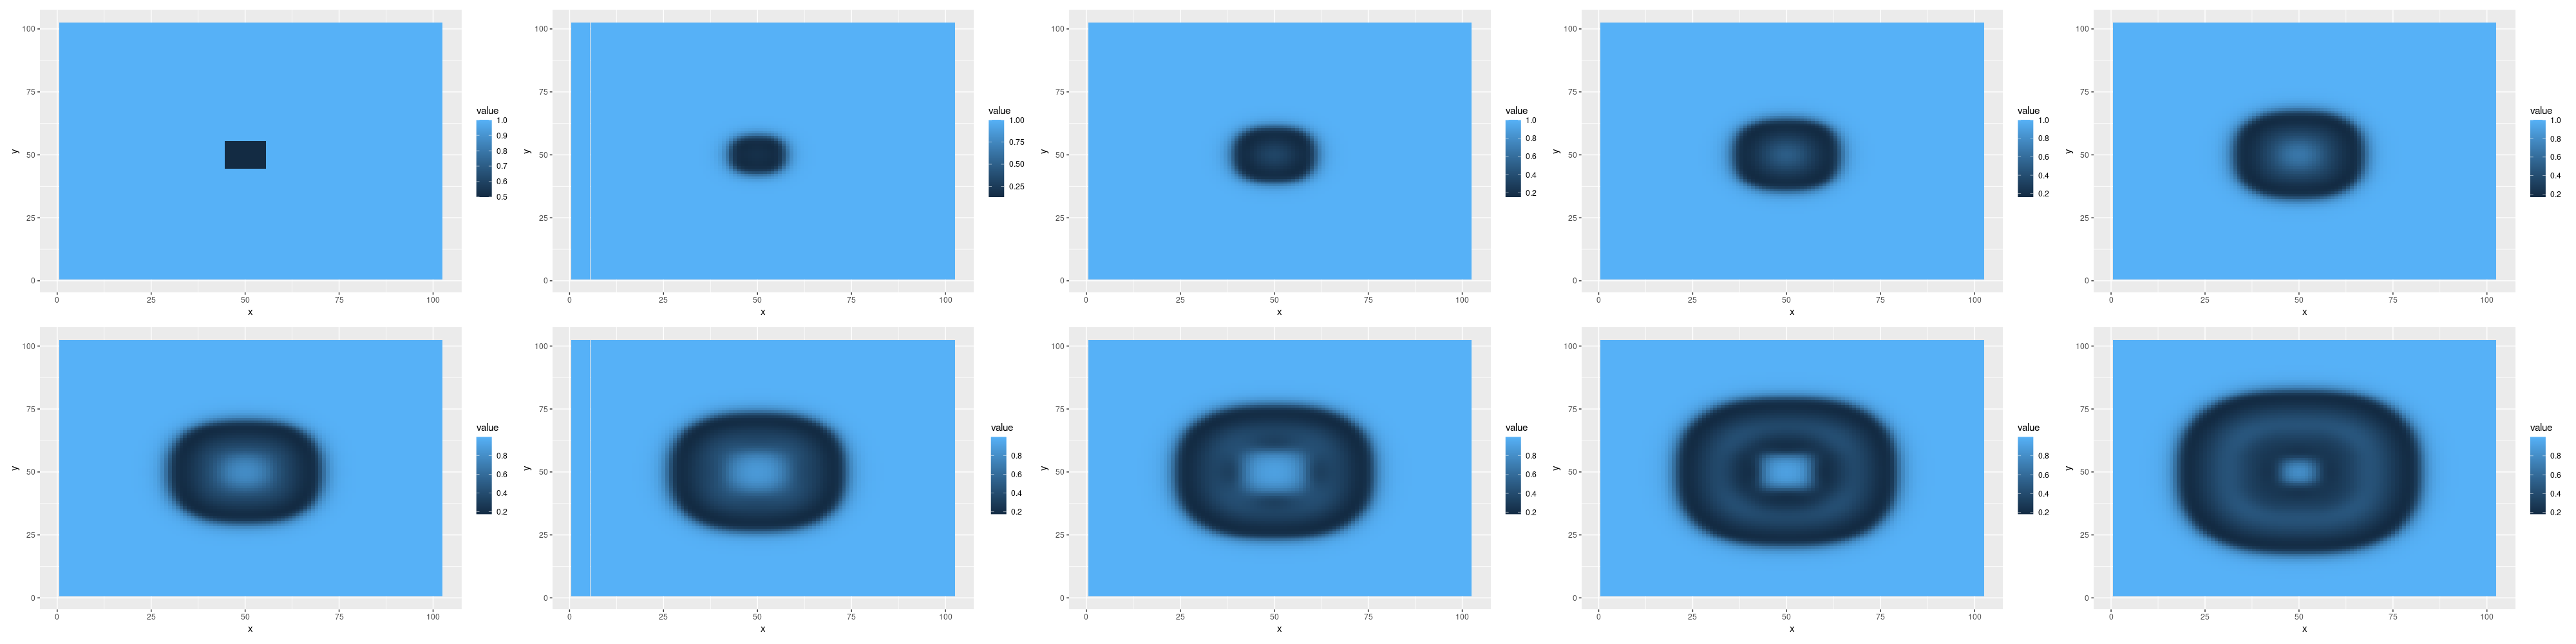

In [17]:
plt <- list()

for (i in 1:num_plt) {
    
    data_temp <- data.frame()
    for (j in 1:nrow(list_plt_u[[i]])) {
        data_temp <- rbind(data_temp,
                           data.frame(x = j, y = 1:ncol(list_plt_u[[i]]),
                                      value = list_plt_u[[i]][j,]))
    }
    
    
    plt[[i]] <- ggplot(data = data_temp, aes(x = x, y = y, fill = value)) +
        geom_tile()
}

options(repr.plot.width = 40, repr.plot.height = 10, repr.plot.res = 100) ## プロットの描画サイズの設定
wrap_plots(plt) + plot_layout(nrow = 2)